<a href="https://colab.research.google.com/github/amamra-abdenour/Deep_Learning_Python/blob/master/DeapLearning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top= False,
                  input_shape=(150,150,3)
)
conv_base.summary()





58892288/58889256 [==============================] - 1s 0us/step


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________________________________________

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-10-04 21:20:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   177MB/s    in 0.4s    

2019-10-04 21:20:58 (177 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import zipfile
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [0]:
import os
import shutil

shutil.rmtree('/content/cats_and_dogs_small_2/')
dataset_dir = '/content/train/'
base_dir ='/content/cats_and_dogs_small_2/'
os.mkdir(base_dir)


In [0]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [0]:
validation_dir_cats = os.path.join(validation_dir, 'cats')
os.mkdir(validation_dir_cats)

validation_dir_dogs = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dir_dogs)

In [0]:
test_dir_cats = os.path.join(test_dir, 'cats')
os.mkdir(test_dir_cats)

test_dir_dogs = os.path.join(test_dir, 'dogs')
os.mkdir(test_dir_dogs)


In [0]:
train_dir_cats = os.path.join(train_dir, 'cats')
os.mkdir(train_dir_cats)

train_dir_dogs = os.path.join(train_dir, 'dogs')
os.mkdir(train_dir_dogs)


In [45]:
#from train folder
print(dataset_dir)
frames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(train_dir_cats,frame)
  shutil.copyfile(src,dst)

/content/train/


In [0]:
frames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(validation_dir_cats,frame)
  shutil.copyfile(src,dst)

In [0]:
frames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(test_dir_cats,frame)
  shutil.copyfile(src,dst)

In [0]:
frames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(train_dir_dogs,frame)
  shutil.copyfile(src,dst)

In [0]:
frames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(validation_dir_dogs,frame)
  shutil.copyfile(src,dst)

In [0]:
frames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(test_dir_dogs,frame)
  shutil.copyfile(src,dst)

In [51]:
print(train_dir_cats)
print(train_dir_dogs)
print(validation_dir_cats)
print(validation_dir_dogs)
print(test_dir_cats)
print(test_dir_dogs)

/content/cats_and_dogs_small_2/train/cats
/content/cats_and_dogs_small_2/train/dogs
/content/cats_and_dogs_small_2/validation/cats
/content/cats_and_dogs_small_2/validation/dogs
/content/cats_and_dogs_small_2/test/cats
/content/cats_and_dogs_small_2/test/dogs


In [52]:
#sanity check
print(len(listdir(train_dir_cats)))
print(len(listdir(train_dir_dogs)))
print(len(listdir(validation_dir_cats)))
print(len(listdir(validation_dir_dogs)))
print(len(listdir(test_dir_cats)))
print(len(listdir(test_dir_dogs)))

1000
1000
500
500
500
500


In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count,4, 4, 512))
    labels = np.zeros(shape =  (sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for input_batch, label_batch in generator:
      features_batch = conv_base.predict(input_batch)
      #print(i * batch_size , (i+1) * batch_size )
      features[i * batch_size : (i + 1) * batch_size] = features_batch
      labels[i * batch_size : (i + 1) * batch_size] = label_batch
      i += 1
      if i * batch_size >= sample_count:
        break
    return features, labels


In [0]:
train_features, train_labels = extract_features(train_dir,2000)
validation_features, validation_labels = extract_features(validation_dir,1000)

In [0]:
print(train_features.shape)
print(train_labels.shape)
print(validation_features.shape)
print(validation_labels.shape)

In [0]:
train_features = np.reshape(train_features,(2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features,(1000, 4 * 4 * 512))

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import binary_crossentropy
from keras.optimizers import rmsprop
from keras.activations import relu, sigmoid

model = Sequential()
model.add(Dense(256, activation = relu, input_dim =(4*4*512)))
model.add(Dropout(0.5))
model.add(Dense(1,activation = sigmoid))

model.compile (optimizer = rmsprop(lr=2e-5),
               loss=binary_crossentropy,
               metrics=['acc'])

history = model.fit(train_features, train_labels, 
          epochs = 30, 
          batch_size = 20, 
          validation_data = (validation_features, validation_labels)
          )
model.save('VGG16_convbase_cats_dogs_1.h5')

In [0]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(val_acc))
plt.plot(epochs,train_acc,'bo',label="Training accuracy")
plt.plot(epochs,val_acc,'r-',label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs validation accuracy')

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(val_loss))
plt.plot(epochs,train_loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,'r-',label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training vs validation loss')

In [54]:
from keras.models import Sequential
from keras import layers
from keras import activations

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [55]:
#freezing the conv_base weights
print(len(model.trainable_weights))
conv_base.trainable = False
print(len(model.trainable_weights))
model.summary()

4
4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [56]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        #shuffle=True,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 15s - loss: 0.6129 - acc: 0.6770 - val_loss: 0.4963 - val_acc: 0.7520
Epoch 2/30
 - 13s - loss: 0.5327 - acc: 0.7250 - val_loss: 0.3983 - val_acc: 0.8460
Epoch 3/30
 - 13s - loss: 0.4692 - acc: 0.7850 - val_loss: 0.3945 - val_acc: 0.8160
Epoch 4/30
 - 13s - loss: 0.4249 - acc: 0.8150 - val_loss: 0.3426 - val_acc: 0.8640
Epoch 5/30
 - 14s - loss: 0.4171 - acc: 0.8150 - val_loss: 0.3263 - val_acc: 0.8680
Epoch 6/30
 - 14s - loss: 0.4049 - acc: 0.8180 - val_loss: 0.2939 - val_acc: 0.8920
Epoch 7/30
 - 13s - loss: 0.3757 - acc: 0.8330 - val_loss: 0.3202 - val_acc: 0.8620
Epoch 8/30
 - 13s - loss: 0.3856 - acc: 0.8340 - val_loss: 0.2840 - val_acc: 0.8880
Epoch 9/30
 - 13s - loss: 0.3594 - acc: 0.8500 - val_loss: 0.2803 - val_acc: 0.8720
Epoch 10/30
 - 13s - loss: 0.3815 - acc: 0.8280 - val_loss: 0.2904 - val_acc: 0.8820
Epoch 11/30
 - 13s - loss: 0.3594 - acc: 0.8440 - val_loss: 0.2892 - val_ac

Text(0.5, 1.0, 'Training vs validation accuracy')

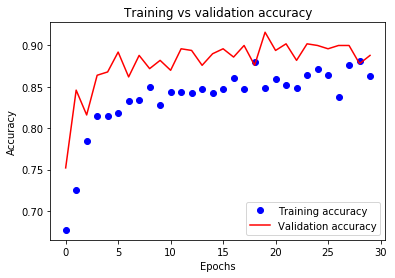

In [57]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(val_acc))
plt.plot(epochs,train_acc,'bo',label="Training accuracy")
plt.plot(epochs,val_acc,'r-',label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs validation accuracy')



Text(0.5, 1.0, 'Training vs validation loss')

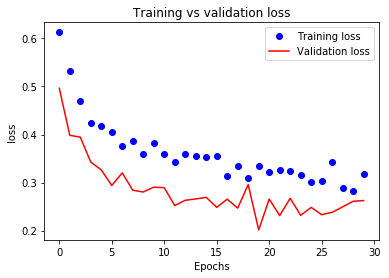

In [58]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(val_loss))
plt.plot(epochs,train_loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,'r-',label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training vs validation loss')

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False


In [60]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 16s - loss: 0.3379 - acc: 0.8500 - val_loss: 0.2547 - val_acc: 0.8960
Epoch 2/30
 - 14s - loss: 0.2795 - acc: 0.8790 - val_loss: 0.2302 - val_acc: 0.9000
Epoch 3/30
 - 14s - loss: 0.2603 - acc: 0.8960 - val_loss: 0.2033 - val_acc: 0.9180
Epoch 4/30
 - 14s - loss: 0.2904 - acc: 0.8630 - val_loss: 0.1929 - val_acc: 0.9200
Epoch 5/30
 - 14s - loss: 0.2513 - acc: 0.8910 - val_loss: 0.2281 - val_acc: 0.9080
Epoch 6/30
 - 14s - loss: 0.2597 - acc: 0.8940 - val_loss: 0.1581 - val_acc: 0.9260
Epoch 7/30
 - 14s - loss: 0.2254 - acc: 0.9020 - val_loss: 0.2101 - val_acc: 0.9140
Epoch 8/30
 - 14s - loss: 0.2129 - acc: 0.9180 - val_loss: 0.2370 - val_acc: 0.9040
Epoch 9/30
 - 14s - loss: 0.1828 - acc: 0.9250 - val_loss: 0.1602 - val_acc: 0.9260
Epoch 10/30
 - 14s - loss: 0.2047 - acc: 0.9200 - val_loss: 0.2303 - val_acc: 0.9160
Epoch 11/30
 - 14s - loss: 0.1855 - acc: 0.9370 - val_loss: 0.2150 - val_acc: 0.9260
Epoch 12/30
 - 14s - loss: 0.1934 - acc: 0.9150 - val_loss: 0.1698 - val_a

Text(0.5, 1.0, 'Training vs validation accuracy')

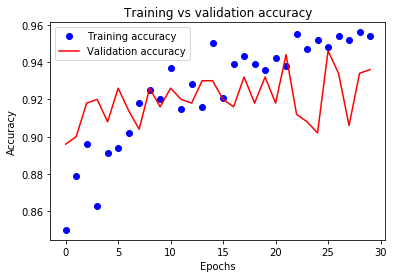

In [61]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(val_acc))
plt.plot(epochs,train_acc,'bo',label="Training accuracy")
plt.plot(epochs,val_acc,'r-',label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs validation accuracy')

Text(0.5, 1.0, 'Training vs validation loss')

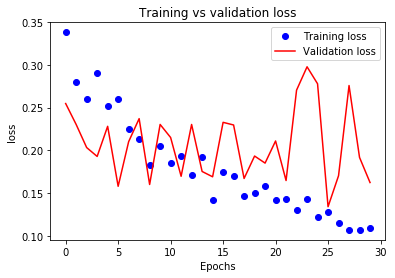

In [62]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(val_loss))
plt.plot(epochs,train_loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,'r-',label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training vs validation loss')

In [0]:
def smooth_points(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points :
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [0]:
val_loss = smooth_points(val_loss)
train_loss = smooth_points(train_loss)

val_acc = smooth_points(val_acc)
train_acc = smooth_points(train_acc)

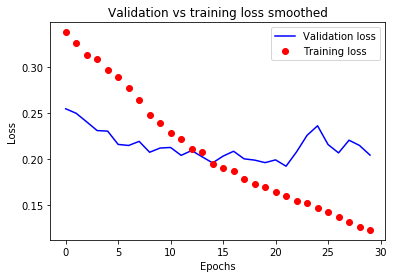

In [65]:
plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.plot(epochs, train_loss, 'ro', label = 'Training loss')
plt.title('Validation vs training loss smoothed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

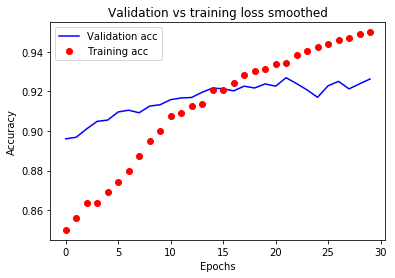

In [66]:
plt.plot(epochs, val_acc, 'b-', label = 'Validation acc')
plt.plot(epochs, train_acc, 'ro', label = 'Training acc')
plt.title('Validation vs training loss smoothed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
from google.colab import files
!pip install -q kaggle

In [68]:
uploaded = files.upload()

MessageError: ignored

In [0]:
#!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json


In [0]:
print(os.listdir('/root/.kaggle/'))

In [0]:
!kaggle competitions download -c dogs-vs-cats -p /content/

In [0]:
import zipfile
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [0]:
print(len(os.listdir('train/')))
#with file.open('sampleSubmission.csv','r') as f:


In [0]:
local_path = os.getcwd()
L = os.listdir(os.path.join(local_path,'train/'))
for i,l in enumerate(L):
  print(l)
  if i == 120:
    break

In [0]:
frames = listdir(dataset_dir+'test/cats/')
for frame in frames:
  src = os.path.join(dataset_dir+'train/cats/', frame)
  dst = os.path.join(train_dir_cats,frame)
  shutil.copyfile(src,dst)

In [69]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode ='binary'
)
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps = 50)
print(test_accuracy, test_loss)

Found 1000 images belonging to 2 classes.
0.9259999930858612 0.20488159330561756


In [0]:
model.save('VGG16_convbase_cats_vs_dogs_final.h5')

In [0]:
print(os.listdir(os.path.join(test_dir,'cats')))
#img_path = os.path.join(test_dir)

In [72]:
img_file = os.path.join(test_dir,'cats/cat.1700.jpg')
print(img_file)

/content/cats_and_dogs_small_2/test/cats/cat.1700.jpg


In [73]:
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_file,target_size=(150,150))
print(type(img))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)
img_tensor /= 255.
print(img_tensor.shape) 

<class 'PIL.Image.Image'>
(150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)


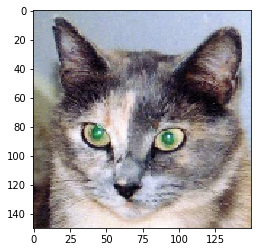

In [74]:
plt.imshow(img_tensor[0])

In [0]:
from keras.models import load_model

# Returns a compiled model identical to the previous one
model = load_model('VGG16_convbase_cats_vs_dogs_final.h5')

In [79]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model =models.Model(inputs=model.input, outputs= layer_outputs)
activations = activation_model.predict(img_tensor)

AttributeError: ignored

In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)